In [1]:
import torch
import math
from torch import nn

In [2]:
torch.__version__

'1.8.0+cpu'

In [3]:
torch.cuda.is_available()

False

In [4]:
#num_heads = 8
source_vocab_size = 100
target_vocab_size = 110
hidden_size = 512
n_batch = 16
maxlen = 1024
pad = 0
dropout_rate = 0.1

### Encoder

In [5]:
class MultiHeadAttention(nn.Module):
    '''
    MultiHeadAttention with Scaled Dot-Product Attention, default to num_heads=8
    '''
    def __init__(self, hidden_size, num_heads=8):
        super().__init__()
        assert hidden_size % num_heads == 0
        self.num_heads = num_heads
        self.attention_head_size = hidden_size // num_heads
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(p=dropout_rate)
        
    def forward(self, q, k, v, mask=None):
        '''
        q: Query tensor of shape [batch_size, maxlen, hidden_size]
        k: Key tensor of shape [batch_size, maxlen, hidden_size]
        v: Value tensor of shape [batch_size, maxlen, hidden_size]
        mask: mask tensor of shape [batch_size, 1, maxlen]
        return: Output tensor of shape [batch_size, maxlen, hidden_size]
        '''
        n_batch = q.size()[0]
        split_shape = (n_batch, -1, self.num_heads, self.attention_head_size)
        
        if mask is not None:
            mask = mask.unsqueeze(1)
            
        # split x for multi-head attention calculation
        query = self.query(q).view(*split_shape).transpose(1,2)
        key = self.key(k).view(*split_shape).transpose(1,2)
        value = self.value(v).view(*split_shape).transpose(1,2)        
        
        # calculate scores
        scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(self.attention_head_size)
        
        # apply mask if mask is not None
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention_prob = self.softmax(scores)
        
        # make context
        context = torch.matmul(attention_prob, value)
        context = self.dropout(context)
                
        # concat multi-head context
        merged_shape = (n_batch, -1, self.num_heads*self.attention_head_size)
        context = context.transpose(1,2).contiguous().view(*merged_shape)
        
        return context

In [6]:
class PositionWiseFeedForwardNetwork(nn.Module):
    '''
    Position-Wise Feedforward Network.
    입력 텐서의 은닉 사이즈 512를 2048로 확장 후 다시 512로 줄임.
    '''
    def __init__(self, hidden_size, inner_hidden_size=2048):
        super().__init__()
        self.w1 = nn.Linear(hidden_size, inner_hidden_size)
        self.relu = nn.ReLU()
        self.w2 = nn.Linear(inner_hidden_size, hidden_size)
        
    def forward(self, x):
        '''
        x: Input tensor of shape [batch_size, maxlen, hidden_size]
        return: Output tensor of shape [batch_size, maxlen, hidden_size]
        '''
        x = self.w1(x)
        x = self.relu(x)
        x = self.w2(x)
        return x

In [7]:
class EncoderLayer(nn.Module):
    '''
    EncoderLayer
    MultiHeadAttention과 PositionWiseFeedForwardNetwork 두 개의 sublayer로 이뤄져 있다.
    위 두 sublayer를 LayerNorm(x + sublayer(x)) 형태로 연산한다. 
    즉, Residual Network와 Layer Normalization을 추가적으로 수행한다.
    '''
    def __init__(self, hidden_size):
        super().__init__()
        self.self_attention = MultiHeadAttention(hidden_size)
        self.feedforward = PositionWiseFeedForwardNetwork(hidden_size)
        self.norm = nn.LayerNorm(hidden_size, eps=1e-6)
        
    def forward(self, x, mask):
        '''
        x: Input tensor of shape [batch_size, maxlen, hidden_size]
        mask: Source mask tensor of shape [batch_size, 1, maxlen]
        return: Output tensor of shape [batch_size, maxlen, hidden_size]
        '''
        x = self.norm(x + self.self_attention(x, x, x, mask=mask))
        x = self.norm(x + self.feedforward(x))
        return x

In [8]:
class PositionalEncoding(nn.Module):
    '''
    PositionalEncoding
    짝수번째에 대해서는 sin함수, 홀수번째에 대해서는 cosine함수 값을 정하여 x값에 더해준다.
    '''
    def __init__(self, hidden_size, dropout, maxlen=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(maxlen, hidden_size)
        position = torch.arange(0, maxlen).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2) *
                             -(math.log(10000.0) / hidden_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        '''
        x: Source input tensor of shape [batch_size, maxlen]
        return: Output tensor of shape [batch_size, maxlen]
        '''
        x = x + torch.autograd.Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [9]:
class Embeddings(nn.Module):
    '''
    Embeddings
    보통의 Embeddings에 sqrt(hidden_size)를 더한 값을 리턴한다.
    '''
    def __init__(self, vocab_size, hidden_size):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab_size, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, x):
        '''
        x: Source Input tensor of shape [batch_size, maxlen]
        return: Output tensor of shape [batch_size, maxlen, hidden_size]
        '''
        return self.lut(x) * math.sqrt(self.hidden_size)

In [10]:
class Encoder(nn.Module):
    '''
    Transformer Encoder
    하나의 Embedding 레이어와 N=6 개의 EncoderLayer로 구성돼 있다.
    리턴할 때는 LayerNormalization 후 리턴한다.
    '''
    def __init__(self, vocab_size, hidden_size, positional_encoding, n=6):
        super().__init__()
        #self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.embedding = nn.Sequential(Embeddings(vocab_size, hidden_size), positional_encoding)
        self.layers = nn.ModuleList([EncoderLayer(hidden_size) for _ in range(n)])
        self.norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x, mask):
        '''
        x: Source input tensor of shape [batch_size, maxlen]
        mask: Source mask tensor of shape [batch_size, 1, maxlen]
        return: Output tensor of shape [batch_size, maxlen, hidden_size]
        
        Example:
        >>> pos_encoder = PositionalEncoding(hidden_size, 0.1)
        >>> encoder = Encoder(vocab_size, hidden_size, pos_encoder)
        >>> inputs = torch.tensor([
        >>>     [1, 15, 35, 45, 5, 8, 10, 2, 0, 0, 0, 0, 0, 0, 0],
        >>>     [1, 4, 7, 66, 34, 33, 13, 4, 8, 2, 0, 0, 0, 0, 0],
        >>>     [1, 25, 5, 6, 77, 24, 8, 5, 9, 27, 2, 0, 0, 0, 0],
        >>>     [1, 16, 13, 8, 3, 75, 37, 9, 2, 0, 0, 0, 0, 0, 0],
        >>> ])
        >>> inputs.shape
        torch.Size([4, 15])
        >>> outputs = encoder(inputs)
        >>> outputs.shape
        torch.Size([4, 15, 512])
        '''
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, mask=mask)
        return self.norm(x)

In [11]:
pos_encoder = PositionalEncoding(hidden_size, 0.1)
encoder = Encoder(source_vocab_size, hidden_size, pos_encoder)

In [12]:
inputs = torch.tensor([
    [1, 15, 35, 45, 5, 8, 10, 2, 0, 0, 0, 0, 0, 0, 0],
    [1, 4, 7, 66, 34, 33, 13, 4, 8, 2, 0, 0, 0, 0, 0],
    [1, 25, 5, 6, 77, 24, 8, 5, 9, 27, 2, 0, 0, 0, 0],
    [1, 16, 13, 8, 3, 75, 37, 9, 2, 0, 0, 0, 0, 0, 0],
])
inputs.shape

torch.Size([4, 15])

In [13]:
inputs_mask = (inputs != pad).unsqueeze(-2)
inputs_mask.shape

torch.Size([4, 1, 15])

In [14]:
outputs = encoder(inputs, inputs_mask)
outputs.shape

torch.Size([4, 15, 512])

### Decoder

In [15]:
class DecoderLayer(nn.Module):
    '''
    DecoderLayer
    EncoderLayer와 같은 블록을 이용하지만 MultiHeadAttention이 한번 더 들어간다.
    그 외 Residual Network나 Layer Normalization을 추가하는 것은 같다.
    '''
    def __init__(self, hidden_size):
        super().__init__()
        self.self_attention_1 = MultiHeadAttention(hidden_size)
        self.self_attention_2 = MultiHeadAttention(hidden_size)
        self.feedforward = PositionWiseFeedForwardNetwork(hidden_size)
        self.norm = nn.LayerNorm(hidden_size, eps=1e-6)
        
    def forward(self, x, m, mask):
        '''
        x: Input tensor of shape [batch_size, maxlen, hidden_size]
        m: Memory tensor of shape [batch_size, maxlen, hidden_size] from the Encoder
        mask: Mask tensor of shape [batch_size, 1, maxlen]
        return: Output tensor of shape [batch_size, maxlen, hidden_size]
        '''
        x = self.norm(x + self.self_attention_1(x, x, x, mask))
        x = self.norm(x + self.self_attention_2(x, m, m, mask))
        x = self.norm(x + self.feedforward(x))
        return x

In [16]:
class Decoder(nn.Module):
    '''
    Transformer Decoder
    하나의 Embedding 레이어와 N=6 개의 DecoderLayer로 구성돼 있다.
    리턴할 때는 LayerNormalization 후 리턴한다.
    
    '''
    def __init__(self, vocab_size, hidden_size, positional_encoding, n=6):
        super().__init__()
        self.embedding = nn.Sequential(Embeddings(vocab_size, hidden_size), positional_encoding)
        self.layers = nn.ModuleList([DecoderLayer(hidden_size) for _ in range(n)])
        self.norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x, m, mask):
        '''
        x: Target input tensor of shape [batch_size, maxlen]
        m: Memory tensor of shape [batch_size, maxlen, hidden_size] from the Encoder
        mask: Target mask tensor of shape [batch_size, 1, maxlen]
        return: Output tensor of shape [batch_size, maxlen, hidden_size]
        '''
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, m, mask=mask)
        return self.norm(x)

In [17]:
pos_encoder = PositionalEncoding(hidden_size, 0.1)
decoder = Decoder(target_vocab_size, hidden_size, pos_encoder)

In [18]:
targets = torch.tensor([
    [1, 55, 35, 65, 25, 4, 15, 12, 9, 2, 0, 0, 0, 0, 0],
    [1, 42, 27, 16, 3, 6, 13, 24, 58, 5, 7, 2, 0, 0, 0],
    [1, 75, 2, 34, 79, 96, 3, 55, 19, 7, 2, 0, 0, 0, 0],
    [1, 66, 24, 3, 13, 83, 24, 19, 3, 2, 0, 0, 0, 0, 0],
])
targets.shape

torch.Size([4, 15])

In [19]:
targets_mask = (targets != pad).unsqueeze(-2)
targets_mask.shape

torch.Size([4, 1, 15])

In [20]:
memory = outputs

In [21]:
outputs = decoder(targets, memory, targets_mask)
outputs.shape

torch.Size([4, 15, 512])

### Transformer

In [22]:
class Transformer(nn.Module):
    '''
    Transformer
    Encoder와 Decoder로 구성된 Transformer 클래스이다.
    Positional Encoding에 사용되는 weight은 공유하기 때문에 pos_encoder를 Encoder와 Decoder 양쪽에서 모두 사용했다.
    '''
    def __init__(self, source_vocab_size, target_vocab_size, hidden_size):
        super().__init__()
        pos_encoder = PositionalEncoding(hidden_size, 0.1)
        self.encoder = Encoder(source_vocab_size, hidden_size, pos_encoder)
        self.decoder = Decoder(target_vocab_size, hidden_size, pos_encoder)
        
    def forward(self, source, target, source_mask, target_mask):
        '''
        source: Source input tensor of shape [batch_size, maxlen]
        target: Target input tensor of shape [batch_size, maxlen]
        source_mask: Source mask tensor of shape [batch_size, 1, maxlen]
        target_mask: Target mask tensor of shape [batch_size, 1, maxlen]
        '''
        print('** source: {}'.format(source.shape))
        print('** target: {}'.format(target.shape))
        print('** source_mask: {}'.format(source_mask.shape))
        print('** target_mask: {}'.format(target_mask.shape))
        memory = self.encoder(source, source_mask)
        print('** encoder output: {}'.format(memory.shape))
        output = self.decoder(target, memory, target_mask)
        print('** decoder output: {}'.format(output.shape))
        return output        

In [23]:
model = Transformer(source_vocab_size, target_vocab_size, hidden_size)

In [24]:
source = torch.tensor([
    [1, 15, 35, 45, 5, 8, 10, 2, 0, 0, 0, 0, 0, 0, 0],
    [1, 4, 7, 66, 34, 33, 13, 4, 8, 2, 0, 0, 0, 0, 0],
    [1, 25, 5, 6, 77, 24, 8, 5, 9, 27, 2, 0, 0, 0, 0],
    [1, 16, 13, 8, 3, 75, 37, 9, 2, 0, 0, 0, 0, 0, 0],
])
source.shape

torch.Size([4, 15])

In [25]:
target = torch.tensor([
    [1, 55, 35, 65, 25, 4, 15, 12, 9, 2, 0, 0, 0, 0, 0],
    [1, 42, 27, 16, 3, 6, 13, 24, 58, 5, 7, 2, 0, 0, 0],
    [1, 75, 2, 34, 79, 96, 3, 55, 19, 7, 2, 0, 0, 0, 0],
    [1, 66, 24, 3, 13, 83, 24, 19, 3, 2, 0, 0, 0, 0, 0],
])
target.shape

torch.Size([4, 15])

In [26]:
source_mask = (source != pad).unsqueeze(-2)
source_mask.shape

torch.Size([4, 1, 15])

In [27]:
target_mask = (target != pad).unsqueeze(-2)
target_mask.shape

torch.Size([4, 1, 15])

In [28]:
out = model(source, target, source_mask, target_mask)
out.shape

** source: torch.Size([4, 15])
** target: torch.Size([4, 15])
** source_mask: torch.Size([4, 1, 15])
** target_mask: torch.Size([4, 1, 15])
** encoder output: torch.Size([4, 15, 512])
** decoder output: torch.Size([4, 15, 512])


torch.Size([4, 15, 512])

In [29]:
source.shape, target.shape, source_mask.shape, target_mask.shape

(torch.Size([4, 15]),
 torch.Size([4, 15]),
 torch.Size([4, 1, 15]),
 torch.Size([4, 1, 15]))

In [30]:
out.shape

torch.Size([4, 15, 512])

### Attention Example

In [31]:
from transformers import BertModel, BertConfig, BertTokenizer
import torch
from matplotlib import pyplot as plt

In [50]:
import seaborn as sns

In [51]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [782]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [800]:
#inp = tokenizer("There is my school and I love this place", return_tensors="pt")
inp = tokenizer("because it is so sweet", return_tensors="pt")
inp

{'input_ids': tensor([[ 101, 2138, 2009, 2003, 2061, 4086,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [801]:
tokenizer.vocab['go']

2175

In [802]:
itov[2293]

'love'

In [803]:
itov = {v:k for k, v in tokenizer.vocab.items()}
list(map(lambda x: itov[x], inp['input_ids'].numpy()[0]))

['[CLS]', 'because', 'it', 'is', 'so', 'sweet', '[SEP]']

In [52]:
inputs = tokenizer("There is my school and I love this place", return_tensors="pt")
outputs = model(**inputs, output_attentions=True)
last_hidden_states = outputs.last_hidden_state

In [53]:
ticklabels = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].detach().numpy())

In [54]:
last_hidden_states.shape

torch.Size([1, 11, 768])

In [56]:
for out in outputs[2]:
    print(out.sum())

tensor(132., grad_fn=<SumBackward0>)
tensor(132., grad_fn=<SumBackward0>)
tensor(132., grad_fn=<SumBackward0>)
tensor(132., grad_fn=<SumBackward0>)
tensor(132., grad_fn=<SumBackward0>)
tensor(132.0000, grad_fn=<SumBackward0>)
tensor(132., grad_fn=<SumBackward0>)
tensor(132., grad_fn=<SumBackward0>)
tensor(132., grad_fn=<SumBackward0>)
tensor(132., grad_fn=<SumBackward0>)
tensor(132., grad_fn=<SumBackward0>)
tensor(132., grad_fn=<SumBackward0>)


In [57]:
ticklabels = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].detach().numpy())

----- 0th Layer -----
----- 1th Layer -----
----- 2th Layer -----
----- 3th Layer -----
----- 4th Layer -----
----- 5th Layer -----
----- 6th Layer -----
----- 7th Layer -----
----- 8th Layer -----
----- 9th Layer -----
----- 10th Layer -----
----- 11th Layer -----


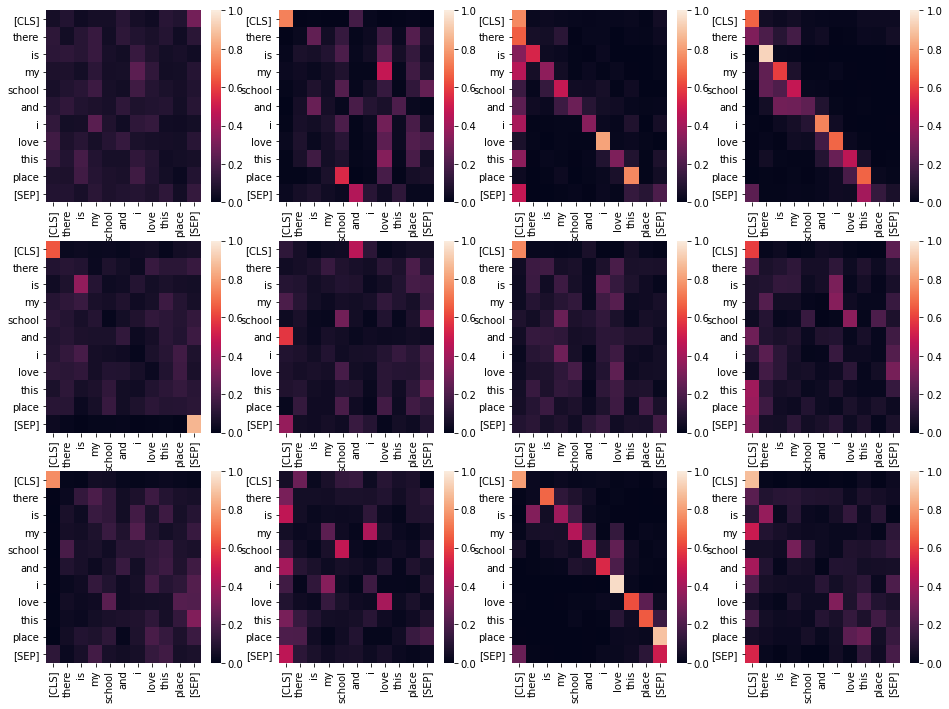

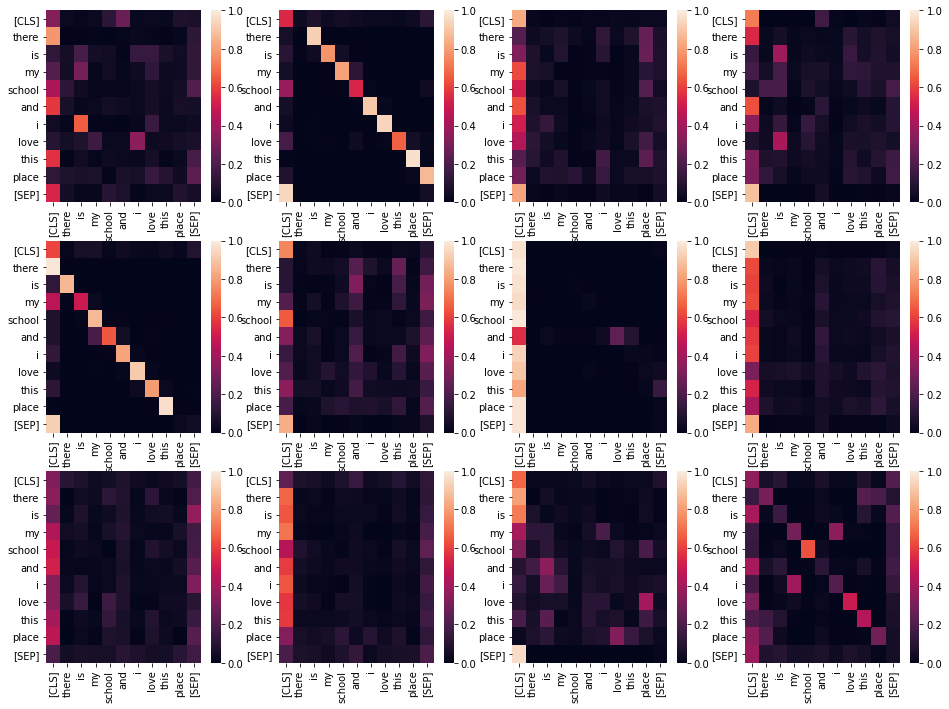

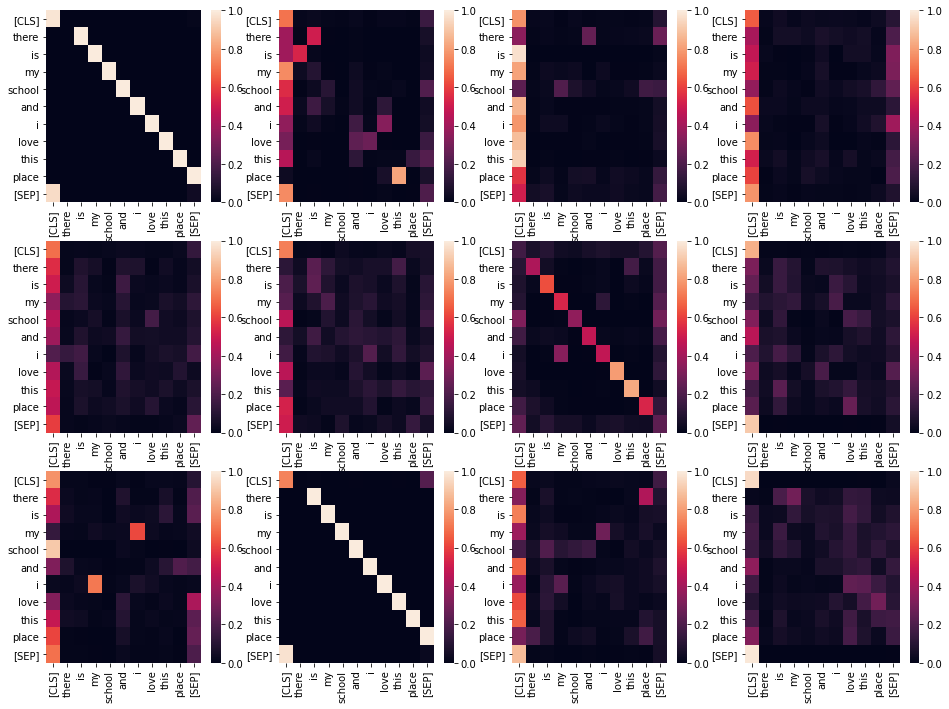

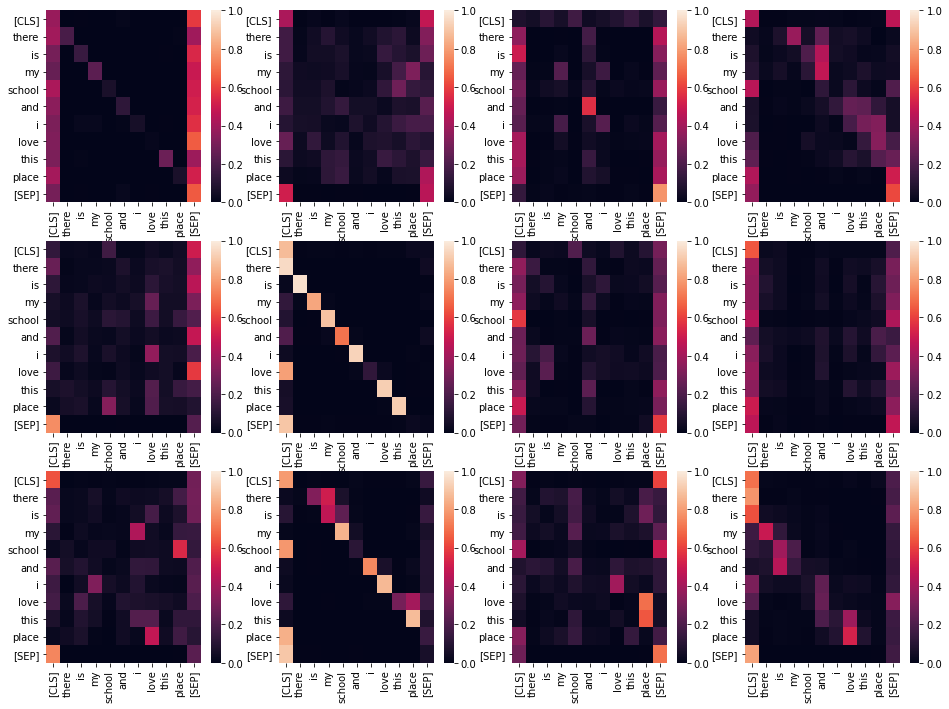

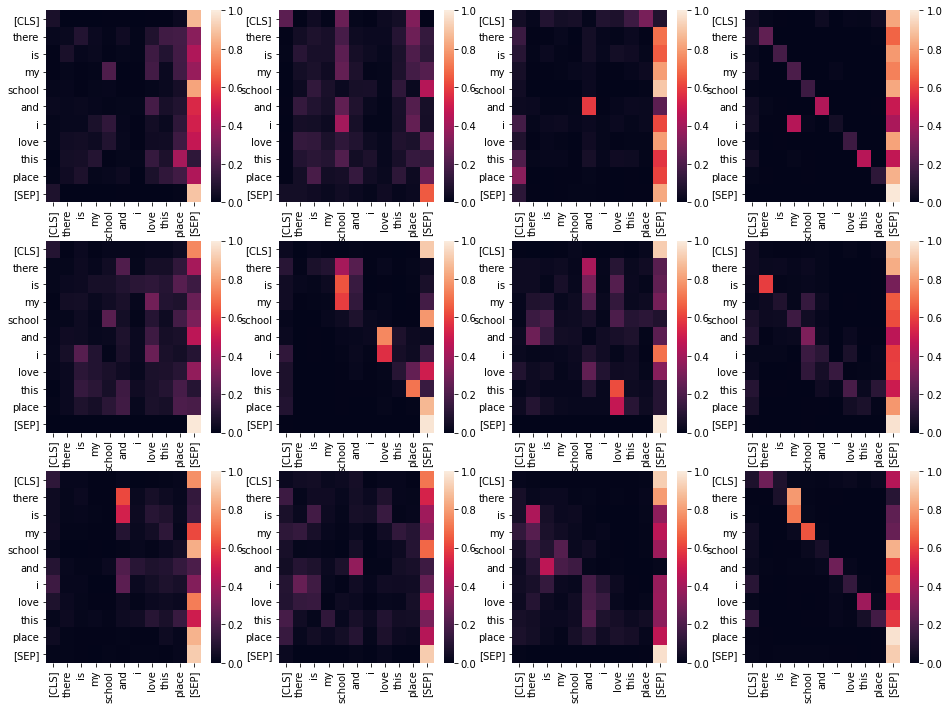

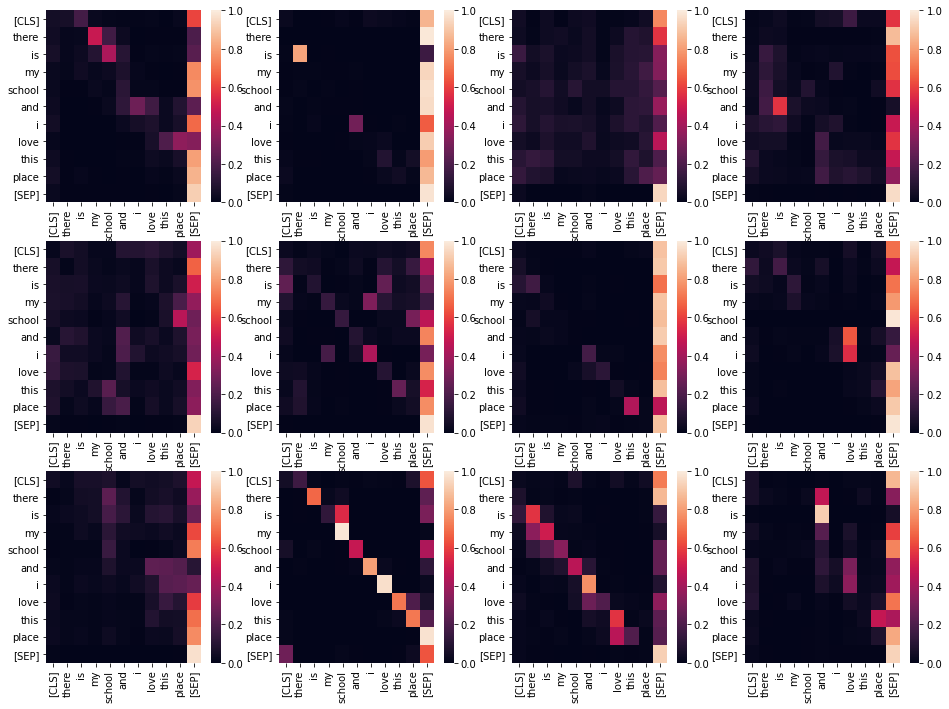

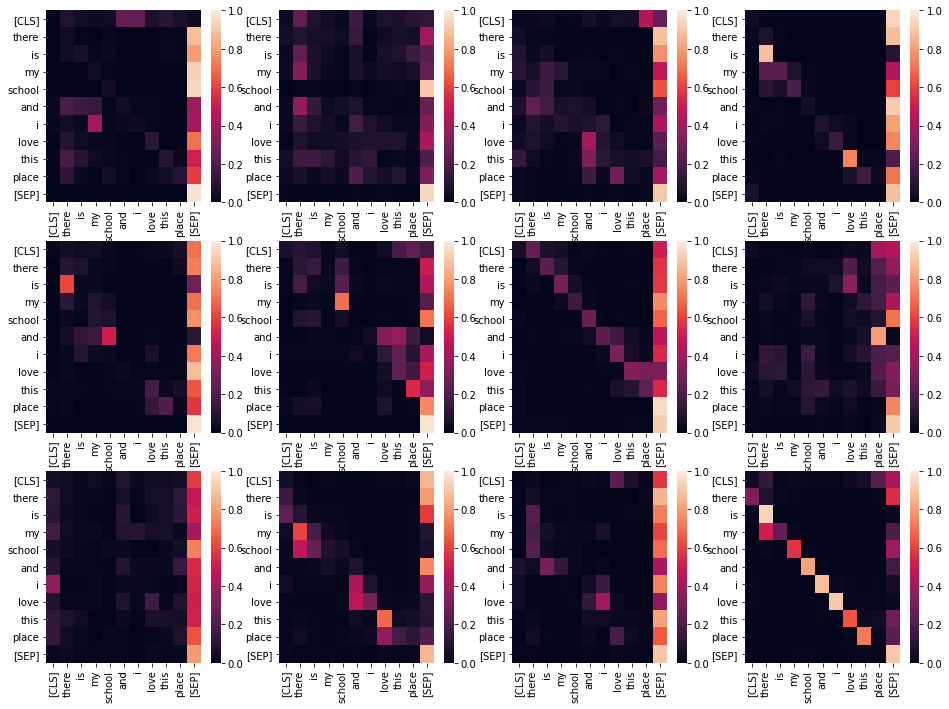

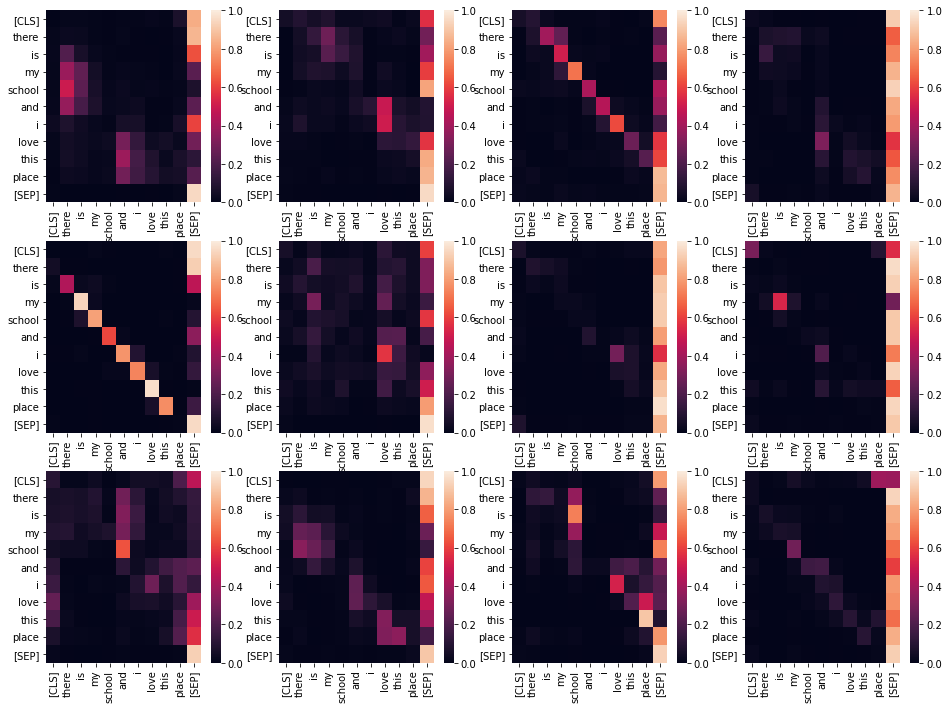

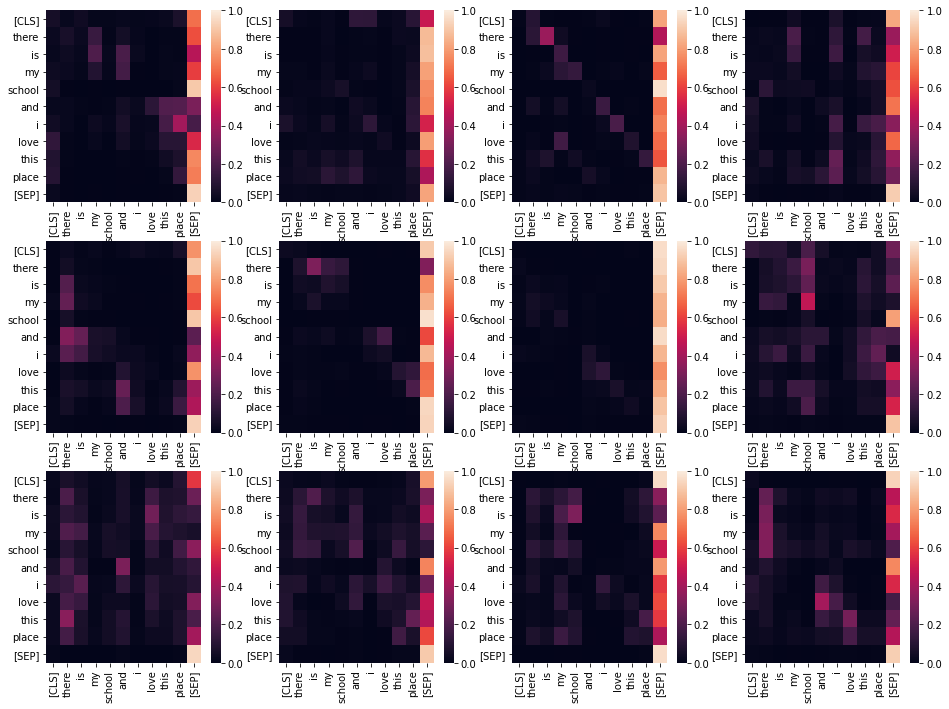

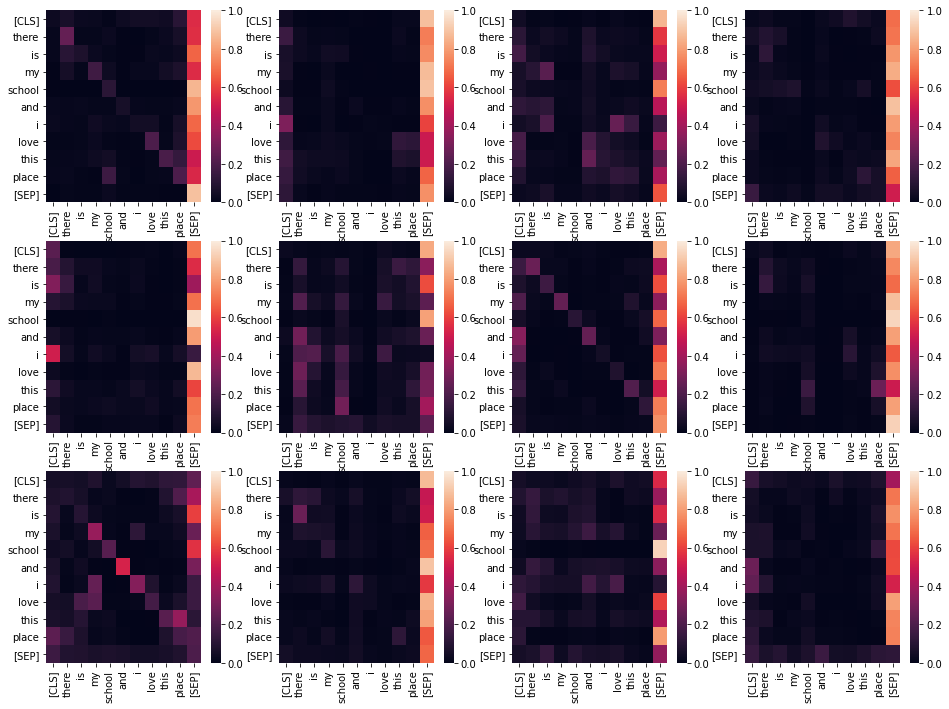

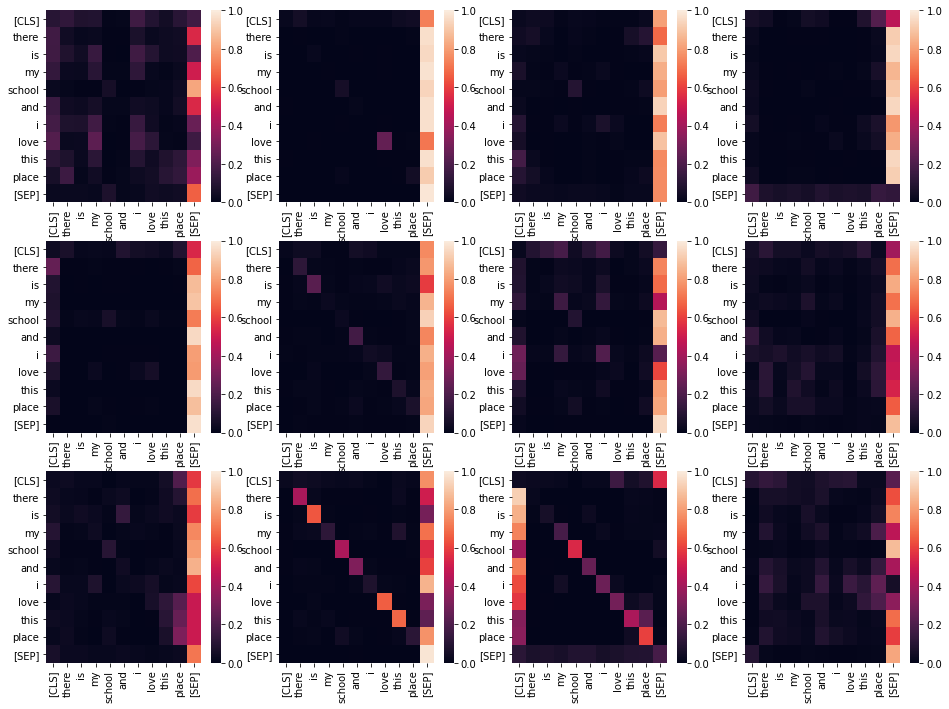

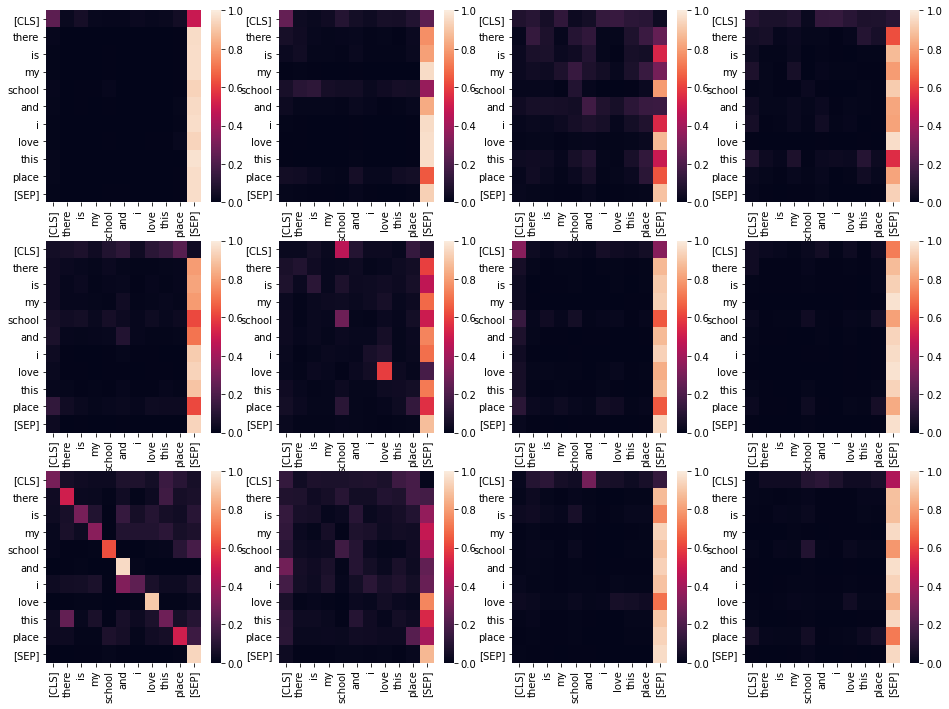

In [58]:
#fig, ((ax00, ax01, ax02, ax03), (ax10, ax11, ax12, ax13), (ax20, ax21, ax22, ax23)) = plt.subplots(3, 4, figsize=(16, 12))
#fig, axs = plt.subplots(3, 4, figsize=(16, 12))
for i, out in enumerate(outputs[2]):
    attention_mats = out[0]
    
    fig, axs = plt.subplots(3, 4, figsize=(16, 12))
    print('----- {}th Layer -----'.format(i))
    for j, att in enumerate(attention_mats):
        att = att.detach().numpy()
        row, col = j//4, j%4
        sns.heatmap(att, vmin=0, vmax=1, ax=axs[row,col], xticklabels=ticklabels, yticklabels=ticklabels)
        
    #break
# uniform_data = np.random.rand(10, 12)
# ax = sns.heatmap(uniform_data)

### English-German Transformer

In [59]:
import torch
from transformer_harvard import *

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

/home/jkfirst/workspace/git/publish/research/transformer/transformer_harvard.py:247: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [ ]:
! pip install torchtext==0.9.0

In [60]:
! wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

--2021-05-10 00:30:30--  https://s3.amazonaws.com/opennmt-models/en-de-model.pt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.80.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.80.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393031182 (375M) [application/x-www-form-urlencoded]
Saving to: ‘en-de-model.pt.2’

en-de-model.pt.2    100%[===================>] 374.82M  5.62MB/s    in 3m 31s  

2021-05-10 00:34:02 (1.77 MB/s) - ‘en-de-model.pt.2’ saved [393031182/393031182]



In [70]:
model, SRC, TGT = torch.load("en-de-model.pt")

In [78]:
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

In [ ]:
inputs = tokenizer("There is my school and I love this place", return_tensors="pt")
outputs = model(**inputs, output_attentions=True)
last_hidden_states = outputs.last_hidden_state

In [80]:
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)

In [82]:
src.shape

torch.Size([1, 16])

In [86]:
model.encoder.layers[0].self_attn.attn[0, 0].shape

torch.Size([16, 16])

### BLEU

In [94]:
! pip install nltk

     |████████████████████████████████| 1.5 MB 1.5 MB/s eta 0:00:01
You should consider upgrading via the '/data_hdd/git/publish/env_pub/bin/python -m pip install --upgrade pip' command.


In [698]:
from collections import Counter
from nltk import ngrams
import nltk.translate.bleu_score as bleu

In [308]:
# 단순 카운트 함수
def simple_count(tokens, n): # 토큰화 된 candidate 문장, n-gram에서의 n 이 두 가지를 인자로 받음.
    return Counter(ngrams(tokens, n)) #문장에서 n-gram을 카운트

In [324]:
def count_clip(candidate, reference_list, n):
    cnt_ca = simple_count(candidate, n)
    # Ca 문장에서 n-gram 카운트
    temp = dict()

    for ref in reference_list: # 다수의 Ref 문장에 대해서 이하 반복
        cnt_ref = simple_count(ref, n)
        # Ref 문장에서 n-gram 카운트

        for n_gram in cnt_ref: # 모든 Ref에 대해서 비교하여 특정 n-gram이 하나의 Ref에 가장 많이 등장한 횟수를 저장
            if n_gram in temp:
                temp[n_gram] = max(cnt_ref[n_gram], temp[n_gram]) # max_ref_count
            else:
                temp[n_gram] = cnt_ref[n_gram]

    return {
        n_gram: min(cnt_ca.get(n_gram, 0), temp.get(n_gram, 0)) for n_gram in cnt_ca
        # count_clip=min(count, max_ref_count)
        # 위의 get은 찾고자 하는 n-gram이 없으면 0을 반환한다.
     }

In [579]:
candidate = 'You love I always'
references = [
    'You know, I always love you so much',
    'Know right? I always love you a lot',
    'Know right? I always love',
]

In [725]:
def modified_precision(candidate, reference_list, n):
    clip = count_clip(candidate, reference_list, n) 
    total_clip = sum(clip.values()) # 분자
    ct = simple_count(candidate, n)
    total_ct = sum(ct.values()) #분모

    if total_ct==0: # n-gram의 n이 커졌을 때 분모가 0이 되는 것을 방지
          total_ct = 1

    #print('modified {}-gram precision: {}/{}'.format(n, total_clip, total_ct))
    return (total_clip / total_ct) # 보정된 정밀도
    # count_clip의 합을 분자로 하고 단순 count의 합을 분모로 하면 보정된 정밀도

In [581]:
def closest_ref_length(candidate, reference_list): # Ca 길이와 가장 근접한 Ref의 길이를 리턴하는 함수
    ca_len = len(candidate) # ca 길이
    ref_lens = (len(ref) for ref in reference_list) # Ref들의 길이
    closest_ref_len = min(ref_lens, key=lambda ref_len: (abs(ref_len - ca_len), ref_len))
    # 길이 차이를 최소화하는 Ref를 찾아서 Ref의 길이를 리턴
    return closest_ref_len

In [727]:
def his_brevity_penalty(candidate, reference_list):
    ca_len = len(candidate)
    ref_len = closest_ref_length(candidate, reference_list)

    if ca_len > ref_len:
        return 1
    elif ca_len == 0 :
    # candidate가 비어있다면 BP = 0 → BLEU = 0.0
        return 0
    else:
        return np.exp(1 - ref_len/ca_len)

In [728]:
def his_bleu_score(candidate, reference_list, weights=[0.25, 0.25, 0.25, 0.25]):
    bp = his_brevity_penalty(candidate, reference_list) # 브레버티 패널티, BP
    p_n = [modified_precision(candidate, reference_list, n=i+1) for i in range(len(weights))]
    
    #p1, p2, p3, ..., pn
    score = np.sum([w_i * np.log(p_i) if p_i != 0 else 0 for w_i, p_i in zip(weights, p_n)])
    return bp * np.exp(score)

In [729]:
his_bleu_score(candidate.split(), list(map(lambda ref: ref.split(), references)))

0.5045666840058485

In [730]:
def word_counter(tokens, n):
    return Counter(ngrams(tokens, n))

In [731]:
def modified_count(candidate, references, n):
    cand_cnt = word_counter(candidate.split(), n)
    temp = Counter()
    for ref in references:
        tokens = ref.split()
        ref_cnt = word_counter(tokens, n)
        for k, v in ref_cnt.items():
            if k in temp:
                temp[k] = max(ref_cnt[k], temp[k])
            else:
                temp[k] = ref_cnt[k]
    
    return Counter({tok:min(temp[tok], cand_cnt[tok]) for tok in cand_cnt})

In [757]:
def modified_ngram_precision(candidate, references, n):
    min_cnt = modified_count(candidate, references, n)
    total_cnt = word_counter(candidate.split(), n)
    
    min_cnt_sum = sum(min_cnt.values())
    total_cnt_sum = sum(total_cnt.values())
    print('modified {}-gram precision: {}/{}'.format(n, min_cnt_sum, total_cnt_sum))
    return min_cnt_sum / total_cnt_sum

In [759]:
candidate = 'You love I always'
references = [
    'You know, I always love you so much',
    'Know right? I always love you a lot',
]
for i in range(4):
    modified_ngram_precision(candidate, references, i+1)


modified 1-gram precision: 4/4
modified 2-gram precision: 1/3
modified 3-gram precision: 0/2
modified 4-gram precision: 0/1


In [760]:
def brevity_penalty(candidate, references):
    cand_len = len(candidate.split())
    diff = np.inf
    for ref in references:
        tokens = ref.split()
        if diff > abs(len(tokens) - cand_len):
            ref_len = len(tokens)
            diff = abs(len(tokens) - cand_len)
            
    if cand_len > ref_len:
        return 1
    elif cand_len == 0:
        return 0
    else:
        return np.exp(1 - ref_len/cand_len)

In [761]:
def bleu_score(candidate, reference_list, weights=[0.25, 0.25, 0.25, 0.25]):
    bp = brevity_penalty(candidate, references)
    precisions = [modified_ngram_precision(candidate, references, n=i+1) for i in range(len(weights))] 
    
    score = 0
    for w, p in zip(weights, precisions):
        if p == 0:
            continue
        score += (w * np.log(p))
    
    return bp * np.exp(score)

In [762]:
bleu_score(candidate, references)

modified 1-gram precision: 4/4
modified 2-gram precision: 1/3
modified 3-gram precision: 0/2
modified 4-gram precision: 0/1


0.27952792741962756

In [768]:
candidate = 'know that I always love you that much.'
candidate = 'You love I always.'
#candidate = 'I I I I I.'
references = [
    'You know, I always love you so much.',
    'Know right? I always love you a lot.'
]
# 정답1: You know, I always love you so much.
# 정답2: Know right? I always love you a lot.

In [769]:
bleu_score(candidate, references)

modified 1-gram precision: 3/4
modified 2-gram precision: 0/3
modified 3-gram precision: 0/2
modified 4-gram precision: 0/1


0.3423503955179092

In [770]:
his_bleu_score(candidate.split(), list(map(lambda ref: ref.split(), references)))

0.3423503955179092

In [739]:
text = '''i can do it right now.please do it right now.it helps you to success'''

In [740]:
sentences = text.split('.')
sentences

['i can do it right now', 'please do it right now', 'it helps you to success']

In [741]:
candidate = sentences[2]
references = [sentences[1], sentences[0]]

In [742]:
candidate.split()

['it', 'helps', 'you', 'to', 'success']

In [743]:
references[0].split()

['please', 'do', 'it', 'right', 'now']

In [753]:
references[1].split()

['It',
 'is',
 'the',
 'guiding',
 'principle',
 'which',
 'guarantees',
 'the',
 'military',
 'forces',
 'always',
 'being',
 'under',
 'the',
 'command',
 'of',
 'the',
 'Party']

In [754]:
for i in range(1, 5):
    weights = [1/i] * i
    s1 = his_bleu_score(candidate.split(), list(map(lambda ref: ref.split(), references)), weights)
    s2 = bleu_score(candidate, references, weights)
    s3 = bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)), candidate.split(), weights)
    print('{}-gram: {:.4f} {:.4f} {:.4f}'.format(i, s1, s2, s3))

1-gram: 0.9444 0.9444 0.9444
2-gram: 0.7454 0.7454 0.7454
3-gram: 0.6241 0.6241 0.6241
4-gram: 0.5046 0.5046 0.5046


In [72]:
# https://github.com/jessevig/bertviz
# → Good attention visualization

In [ ]:
import math
import torch.nn.functional as F

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
class MultiHeadedAttention_(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention_, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        print(self.linears[0])
        print(self.linears[0](query).shape)
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        
        print(self.d_k, self.h)
        print(query.shape, key.shape, value.shape)
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        print(x.shape)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [ ]:
multi_head_attention = MultiHeadedAttention_(num_heads, hidden_size)

In [ ]:
x = torch.rand((n_batch, maxlen, hidden_size))
x.shape

In [ ]:
ta = multi_head_attention(x, x, x)
print('{} → {}'.format(x.shape, ta.shape))

In [ ]:
import copy

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
linears = clones(nn.Linear(3, 3), 4)

In [ ]:
for k, v in zip(linears, (multi_head_attention.query, multi_head_attention.key, multi_head_attention.value)):
    print(k, v.in_features)

In [ ]:
import numpy as np

In [ ]:
a = [
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2],
    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
]
a = np.array(a)
a = torch.tensor(a)
emb = nn.Embedding(4, 10)
a = emb(a)

In [ ]:
a.shape

In [ ]:
a[0][:]

In [ ]:
ta = a.view(4, -1, 2, 5)

In [ ]:
ta.shape

In [ ]:
ta[0]

### FaceBoxes

In [ ]:
def number_of_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-5)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [ ]:
class Inception(nn.Module):

    def __init__(self):
        super(Inception, self).__init__()
        self.branch1x1 = BasicConv2d(128, 32, kernel_size=1, padding=0)
        self.branch1x1_2 = BasicConv2d(128, 32, kernel_size=1, padding=0)
        self.branch3x3_reduce = BasicConv2d(128, 24, kernel_size=1, padding=0)
        self.branch3x3 = BasicConv2d(24, 32, kernel_size=3, padding=1)
        self.branch3x3_reduce_2 = BasicConv2d(128, 24, kernel_size=1, padding=0)
        self.branch3x3_2 = BasicConv2d(24, 32, kernel_size=3, padding=1)
        self.branch3x3_3 = BasicConv2d(32, 32, kernel_size=3, padding=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch1x1_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch1x1_2 = self.branch1x1_2(branch1x1_pool)

        branch3x3_reduce = self.branch3x3_reduce(x)
        branch3x3 = self.branch3x3(branch3x3_reduce)

        branch3x3_reduce_2 = self.branch3x3_reduce_2(x)
        branch3x3_2 = self.branch3x3_2(branch3x3_reduce_2)
        branch3x3_3 = self.branch3x3_3(branch3x3_2)

        outputs = [branch1x1, branch1x1_2, branch3x3, branch3x3_3]
        return torch.cat(outputs, 1)

In [ ]:
class CRelu(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-5)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = torch.cat([x, -x], 1)
        x = F.relu(x, inplace=True)
        return x

In [ ]:
class FaceBoxes(nn.Module):

    def __init__(self, phase, size, num_classes):
        super(FaceBoxes, self).__init__()
        self.phase = phase
        self.num_classes = num_classes
        self.size = size

        self.conv1 = CRelu(3, 24, kernel_size=7, stride=4, padding=3)
        self.conv2 = CRelu(48, 64, kernel_size=5, stride=2, padding=2)
        print('conv1: {}'.format(number_of_params(self.conv1)))
        print('conv2: {}'.format(number_of_params(self.conv2)))

        self.inception1 = Inception()
        self.inception2 = Inception()
        self.inception3 = Inception()
        print('inception1: {}'.format(number_of_params(self.inception1)))
        print('inception2: {}'.format(number_of_params(self.inception2)))
        print('inception3: {}'.format(number_of_params(self.inception3)))

        self.conv3_1 = BasicConv2d(128, 128, kernel_size=1, stride=1, padding=0)
        self.conv3_2 = BasicConv2d(128, 256, kernel_size=3, stride=2, padding=1) # 29%
        print('conv3_1: {}'.format(number_of_params(self.conv3_1)))
        print('conv3_2: {}'.format(number_of_params(self.conv3_2)))

        self.conv4_1 = BasicConv2d(256, 128, kernel_size=1, stride=1, padding=0)
        self.conv4_2 = BasicConv2d(128, 256, kernel_size=3, stride=2, padding=1)  # 29%
        print('conv4_1: {}'.format(number_of_params(self.conv4_1)))
        print('conv4_2: {}'.format(number_of_params(self.conv4_2)))
        
        self.loc, self.conf = self.multibox(self.num_classes)
        print('loc: {}'.format(number_of_params(self.loc)))  # 10%
        print('conf: {}'.format(number_of_params(self.conf)))

        if self.phase == 'test':
            self.softmax = nn.Softmax(dim=-1)

        if self.phase == 'train':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    if m.bias is not None:
                        nn.init.xavier_normal_(m.weight.data)
                        m.bias.data.fill_(0.02)
                    else:
                        m.weight.data.normal_(0, 0.01)
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()

    def multibox(self, num_classes):
        loc_layers = []
        conf_layers = []
        loc_layers += [nn.Conv2d(128, 21 * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(128, 21 * num_classes, kernel_size=3, padding=1)]
        loc_layers += [nn.Conv2d(256, 1 * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(256, 1 * num_classes, kernel_size=3, padding=1)]
        loc_layers += [nn.Conv2d(256, 1 * 4, kernel_size=3, padding=1)]
        conf_layers += [nn.Conv2d(256, 1 * num_classes, kernel_size=3, padding=1)]
        return nn.Sequential(*loc_layers), nn.Sequential(*conf_layers)

    def forward(self, x):

        detection_sources = list()
        loc = list()
        conf = list()

        x = self.conv1(x)
        print(x.shape)
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        print(x.shape)
        x = self.conv2(x)
        print(x.shape)
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        print(x.shape)
        x = self.inception1(x)
        print(x.shape)
        x = self.inception2(x)
        print(x.shape)
        x = self.inception3(x)
        print(x.shape)
        detection_sources.append(x)

        x = self.conv3_1(x)
        print(x.shape)
        x = self.conv3_2(x)   # large weight 29%
        print(x.shape)
        detection_sources.append(x)

        x = self.conv4_1(x)
        print(x.shape)
        x = self.conv4_2(x)   # large weight 29%
        print(x.shape)
        detection_sources.append(x)

        for (x, l, c) in zip(detection_sources, self.loc, self.conf):
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())

        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)    # large weight 10%
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        if self.phase == "test":
            output = (loc.view(loc.size(0), -1, 4),
                    self.softmax(conf.view(conf.size(0), -1, self.num_classes)))
        else:
            output = (loc.view(loc.size(0), -1, 4),
                    conf.view(conf.size(0), -1, self.num_classes))

        return output

In [ ]:
img_dim = 1024
num_classes = 2
m1 = FaceBoxes('train', img_dim, num_classes)

In [ ]:
number_of_params(m1)

In [ ]:
inputs = torch.rand((16, 3, 500, 500))

In [ ]:
o = m1(inputs)

In [ ]:
img_dim = 1024
num_classes = 2
m1 = FaceBoxes('train', img_dim, num_classes)

In [ ]:
5. BERT
<블록 시작>
아직 말을 못하는 윤우한테 지난 2년간 윤우 엄마 아빠는 매일 매일 이런 저런 얘기를 해줬다. 
드디어 윤우는 조금씩 단어를 말하기 시작하면서 두 개의 단어를 연결해서 말을 하기 시작한다. "맘마 마니~"
아빠의 질문에 대답도 한다. "윤우 잠 얼마나 잤어?" "마니~"
<블록 끝>

아무 것도 모르는 아이들에게 알아듣든 못 알아듣든 엄마 아빠는 계속 말을 해준다. 그러면 자연스럽게 조금씩 언어를 배워나가기 시작한다. 단어 하나를 학습하게 되고 두개를 학습하게 되고, 단어와의 관계를 학습하며 순서도 학습하게 된다. 특정 단어들끼리는 항상 같이 붙어 다닌다는 것을 알게 되며 나아가 문맥간의 논리적인 관계도 이해하게 된다. 컴퓨터로 하여금 언어를 이해하게 하기 위해서 확률 기반의 N-gram 방식을 오랫동안 사용했었고 이를 2장에서 설명했다. 그리고 인공지능 기법을 이용해서 컴퓨터가 언어를 이해하게 하는 방법을 3장에서 설명헀다. 그 다음 4장 트랜스포머에서 번역기를 타겟팅한 획기적인 모델을 소개했다. 이번 장에서 소개할 BERT는 트랜스포머의 구조를 이용해서 만든 언어모델이다.

5.1. BERT의 입력 살펴보기
BERT에 대해서 자세하게 살펴보기 전에 우선 BERT의 입력 데이터가 어떤 형태를 띄는지 살펴보자. 4장 트랜스포머는 기계 번역을 학습한 모델이기 떄문에 입력 데이터가 번역할 문장(source)과 번역된 문장(target)으로 이뤄져 있었고, 이 문장들은 토크나이져를 통해서 토큰화되어 입력됐다. BERT도 트랜스포머처럼 토크나이저를 통해 트큰화된 문장이 입력으로 사용된다. 아래의 예시를 보자.
<코드 시작>
코드1
>>> from transformers import BertTokenizer
>>> tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
>>> inp = tokenizer("There is my school and I love this place", return_tensors="pt")
>>> inp
{'input_ids': tensor([[ 101, 2045, 2003, 2026, 2082, 1998, 1045, 2293, 2023, 2173,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
>>> itov = {v:k for k, v in tokenizer.vocab.items()}
>>> list(map(lambda x: itov[x], inp['input_ids'].numpy()[0]))
['[CLS]', 'there', 'is', 'my', 'school', 'and', 'i', 'love', 'this', 'place', '[SEP]']
<코드 끝>

[코드1]은 BERT의 토크나이저를 로딩해서 문장 "There is my school and I love this place"를 토큰화한 코드이다. 위 결과에서 token_type_ids와 attention_mask에 대해서는 나중에 설명할 예정이니 지금은 무시하고 input_ids만 보자. input_ids는 101로 시작하고 102로 끝나는 텐서로 표현되고 있는데, 이것을 토크나이저의 vocab을 이용해서 역으로 치환하면 ['CLS', 'there', 'is', ..., 'place', '[SEP]']이 된다. 참고로 [코드1]에서 사용한 토크나이저는 사전에 학습돼 있는 토크나이저이고 from_pretrained를 이용해서 다운로드 받아서 사용할 수 있다.

정리하자면 BERT의 입력은 기본적으로 사전학습된 토크나이저를 통해서 토큰화해서 만들 수 있고 token_type_ids와 attention_mask 등이 추가되어 들어간다.

5.2. 사전학습 이해하기
BERT의 입력에 대해서 이전 절에서 살펴봤다. 그 입력을 이용해서 사전학습을 하게 되는데, 이번 적에서는 사전학습에 대해서 이야기해보자. 사전학습(Pre-training)의 사전은 미리의 의미를 지닌 사전(事前)이다. 사전학습된 언어모델이라 함은 미리 학습된 언어모델이라는 것이다. BERT는 미리 학습된 언어모델이다. BERT의 구조는 4장에서 소개한 트랜스포머의 인코더 구조를 띄고 있는데 이 구조에 데이터를 넣어서 학습시킨 것이 사전학습된 BERT이고, 이 사전학습된 BERT는 이미 Google이나 HuggingFace, SKT 등등의 큰 기업 또는 오픈소스 프로젝트에서 많은 컴퓨팅 리소스를 이용해서 학습해뒀고, 학습된 모델을 다운로드 받아서 활용할 수 있다. 

그러면 어떻게 BERT를 사전학습했을까? 직접 학습을 해보기는 힘들어도 원리를 이해해볼 수는 있다. BERT의 사전학습은 언어에 대한 사전학습이다. 따라서 언어를 학습할 때 어떤 식으로 학습하는지를 먼저 생각해보자. Masked Language Model(MLM)과 Next Sentence Prediction(NSP)를 통해 학습을 한다. BERT는 MLM과 NSP의 Loss를 낮추는 방식으로 학습된다. 그러면 MLM과 NSP가 각각 어떤 학습을 하는지 다음 절에서 자세하게 알아보자.

5.1.1. Masked Language Model (MLM)
MLM은 쉽게 말해서 빈 칸 체우기이다. 토큰화되어 들어오는 BERT의 입력을 임의로 마스킹하고 마스킹된 값들을 맞추는 멀티 레이블 분류 문제이다. 즉 입력 토큰의 일부를 임의로 몇 개 선택해서 레이블을 스스로 만든 후에 그 레이블을 다시 맞추는 분류 문제이다. 실제로 사람이 언어를 학습할 때 문제집에서 빈 칸 체우기 문제를 풀면서 학습을 한다. 그 방법을 컴퓨터에게 적용한 것이라고 생각하면 된다. 아래의 예시를 보자.
<블록 시작>
입력 토큰: ['[CLS]', 'there', 'is', 'my', 'school', 'and', 'i', 'love', 'this', 'place', '[SEP]']
마스킹된 토큰: ['[CLS]', 'there', 'is', '[MASK]', 'school', 'and', 'i', '[MASK]', 'this', '[MASK]', '[SEP]']
레이블: [-100, -100, -100, 2026, -100, -100, -100, 2293, -100, 2173, -100]
<블록 끝>

my, love, place가 임의로 선택됐으니 이 토큰들을 마스킹한 후 다시 원래의 토큰인 2026, 2293, 2173으로 맞추는 분류 문제인 것이다. MLM 학습은 이렇게 스스로 레이블을 만들어서 학습하게 되므로 self-supervised learning이라고 한다. MLM을 조금 더 자세하게 알기 위해서 BERT 논문에서 MLM을 설명하는 부분을 살펴보자.
<블록 시작>
인용1
link: https://arxiv.org/pdf/1810.04805.pdf
The training data generator
chooses 15% of the token positions at random for
prediction. If the i-th token is chosen, we replace
the i-th token with (1) the [MASK] token 80% of
the time (2) a random token 10% of the time (3)
the unchanged i-th token 10% of the time. Then,
Ti will be used to predict the original token with
cross entropy loss.
<블록 끝>

[인용1]을 보면 입력 토큰의 15 퍼센트에 해당하는 토큰을 임의로 정한 후, 선택된 15% 중 80%는 [MASK] 토큰으로 바꾸고 10%는 랜덤 토큰으로 변경하고 나머지 10%는 바꾸지 않는다고 한다. 원래의 정답이 분명하게 있는데 왜 굳이 일부는 바꾸고 일부는 바꾸지 않고 등등의 복잡한 과정을 거치는 것일까? 다시 한번 말하자면, MLM은 빈 칸 체우기 문제이다. 빈 칸 체우기 문제인데 [MASK] 토큰에 대해서만 정답을 맞춘다. 최초에 선택된 15%에 대해서만 예측을 하고 나머지 85%는 무시된다. 만일 [인용1]과 같은 마스킹 전략을 거치지 않는다면 모델은 [MASK]된 것에 대해서만 빈 칸을 맞출 줄 아는 모델로 학습돼 버리고 만다. 그런데 [MASK]는 Fine-Tuning과정에서는 절대 나오지 않는 토큰이고 MLM의 목적은 빈 칸 체우기를 통해 문맥을 학습하는 것이다. 따라서 [MASK]라고 선택된 토큰들 중에서 10%는 랜덤한 단어로 치환하고 또 다른 10%는 원래의 입력 토큰을 그대로 가져가는 전략을 사용하는 것이다. 이렇게 하면 [MASK]로 돼 있지 않는 부분에 대해서도 MLM은 예측을 수행할 수 있게 돼서 언어의 문맥을 학습할 수 있게 된다.

MLM에 대한 예시를 아래의 예시를 통해 확인해보자.
<블록 시작>
input ids: [101, 2045, 2003, 2026, 2082, 1998, 1045, 2293, 2023, 2173,  102]
input token: ['[CLS]', 'there', 'is', 'my', 'school', 'and', 'i', 'love', 'this', 'place', '[SEP]'] 
마스킹된 token: ['[CLS]', 'there', 'is', '[MASK]', 'school', 'and', 'i', '[MASK]', 'this', '[MASK]', '[SEP]']
마스킹 전략 후의 token: ['[CLS]', 'there', 'is', '[MASK]', 'school', 'and', 'i', 'go', 'this', 'place', '[SEP]']
마스킹 전략 후의 input_ids: [101, 2045, 2003, 103, 2082, 1998, 1045, 2293, 2023, 2173,  102]
※ [MASK]: 103
※ go: 2175
※ place: 2173
label: [-100, -100, -100, 2026, -100, -100, -100, 2293, -100, 2173, -100]
※ my: 2026
※ love: 2293
※ place: 2173
<블록 끝>

위의 예시에서 "input_token"에서 임의로 my, love, place 세 토큰을 골랐다고 하자. 그리고 my는 [MASK]로, love는 go로 place는 그대로 place로 둬서 마스킹 전략을 적용시키자. 원래 대로라면 [인용1]에서 소개한 마스킹 전략과 같이 80%/10%/10%의 비율을 유지해야 하지만 여기에서는 편의상 비율은 무시하도록 하자. 위의 예시의 "마스킹 전략 후의 token"을 보라. MLM을 수행해야 하는 토큰은 총 3개이다. 4번째 자리에 있는 [MASK]를 my로 예측해야 하고, 8번째 자리에 있는 go를 love로 예측해야 하고, 10번째 자리에 있는 place는 그대로 place로 예측하면 된다. 예측할 때 처음에 [MASK]로 선택되지 않았던 85%에 해당하는 부분에 대해서는 예측을 수행하지 않는다.

복잡하게 느껴질 수 있어서 MLM 과정을 순서대로 정리해봤다.
<블록 시작>
STEP1: 사전 학습된 토크나이저를 이용해서 문장을 토큰화해서 숫자로 바꾼다.
STEP2: STEP1에서 숫자로 바뀐 토큰들 중 15%를 랜덤으로 선택한다.
STEP3: label을 만들어둔다. label을 만들 때는 STEP2에서 선택되지 않은 85%는 -100으로 두고 선택된 15%는 그대로 둔다.
STEP4: STEP2에서 선택된 15% 중 80%는 [MASK] 토큰인 103으로 변경하고, 10%는 임의의 다른 숫자로 변경하고, 나머지 10%는 그대로 둔다.

STEP3에서 만든 것이 MLM의 label이고 STEP4에서 만든 것이 MLM의 입력 값이다.

STEP5: STEP3과 STEP4에서 만든 값을 이용해서 MLM loss를 구한다. Loss를 구할 때 label에서 -100으로 돼 있는 부분에 대해서는 loss를 계산하지 않도록 무시해준다.
<블록 끝>

5.1.2. Next Sentence Prediction (NSP)
MLM이 빈 칸 체우기를 학습하는 것이라면 NSP는 다음 문장 맞추기를 학습하는 과정이다. 두 문장이 주어졌을 때 그 두 문장이 앞/뒤 문장 관계인지(is_next=1) 그렇지 않으면 그냥 랜덤한 문장인지를(is_next=0) 학습한다. NSP는 두 문장이 is_next인지 아닌지를 판단하는 문제이기 때문에 입력 데이터 자체가 두 문장으로 이루어진 쌍으로 돼 있다. 이 두 문장을 sentence_a와 sentence_b라고 하자. sentence_a와 sentence_b의 앞뒤에는 예약어 토큰을 추가해줘야 한다. 예약어는 아래와 같이 추가해준다.
<블록 시작>
[CLS] sentence_a [SEP] sentence_b [SEP]
<쁠록 끝>

위의 예시에서 sentence_a의 앞뒤에는 [CLS]와 [SEP]이 추가됐다. sentence_a가 처음 시작이니 그 앞에 [CLS]를 붙여주는 것이고 sentence_a가 끝난 시점에 또 다시 [SEP]을 붙여준 것이다. 그리고 sentence_b를 추가해주고 끝나는 지점에 한번 더 [SEP]을 추가해서 입력 데이터를 만드는 것이다. 이렇게 만들어진 입력 데이터에 대해서 sentence_a와 sentence_b의 관계에 따라 is_next=0 또는 is_next=1이 될 수 있다.
<블록 시작>
# is_next=0
sentence_a: I love this candy
sentence_b: I read a good news
input: ['[CLS]', 'i', 'love', 'this', 'candy', '[SEP]', 'i', 'read', 'a', 'good', 'news', '[SEP]']
label: 0

# is_next=1
sentence_a: I love this candy
sentence_b: Because it is so sweet
input: ['[CLS]', 'i', 'love', 'this', 'candy', '[SEP]', 'because', 'it', 'is', 'so', 'sweet', '[SEP]']
label: 1
<블록 끝>

5.1.3. 사전학습을 위한 데이터셋 준비와 Self-supervised learning




### Reference
- 유투브 비디오: https://www.youtube.com/watch?v=q9NS5WpfkrU 
- MLM 실제 전략: https://towardsml.com/2019/09/17/bert-explained-a-complete-guide-with-theory-and-tutorial/

In [804]:
! pip install opencv2

ERROR: Could not find a version that satisfies the requirement opencv2 (from versions: none)
ERROR: No matching distribution found for opencv2
You should consider upgrading via the '/data_hdd/git/publish/env_pub/bin/python -m pip install --upgrade pip' command.


In [36]:
original_token = ['[CLS]', 'have', 'eyes', 'to', 'wonder', ',', 'but', 'lack', 'tongues', 'to', 'praise', '.', 'not', 'mine', 'own', 'fears', ',', 'nor', 'the', 'prophet', '##ic', 'soul', ',', 'of', 'the', 'wide', 'world', ',', 'dreaming', 'on', 'things', '[SEP]']

In [37]:
original_ids = [  101,  2031,  2159,  2000,  4687,  1010,  2021,  3768, 19677,  2000,
         8489,  1012,  2025,  3067,  2219, 10069,  1010,  4496,  1996, 12168,
         2594,  3969,  1010,  1997,  1996,  2898,  2088,  1010, 12802,  2006,
         2477,   102]

In [38]:
indice = [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0]

In [43]:
input_token = ['[CLS]', 'have', '[MASK]', 'to', '[MASK]', ',', 'but', 'lack', 'tongues', 'to', 'praise', '.', '[MASK]', '1843', 'own', 'fears', ',', 'nor', 'the', 'prophet', '##ic', 'soul', '[MASK]', 'of', 'the', 'wide', 'world', ',', 'dreaming', 'on', 'things', '[SEP]']

In [39]:
input_ids = [  101,  2031,   103,  2000,   103,  1010,  2021,  3768, 19677,  2000,
         8489,  1012,   103, 10075,  2219, 10069,  1010,  4496,  1996, 12168,
         2594,  3969,   103,  1997,  1996,  2898,  2088,  1010, 12802,  2006,
         2477,   102]

In [40]:
labels = [-100, -100, 2159, -100, 4687, -100, -100, -100, -100, -100, -100, 1012,
        2025, 3067, -100, -100, -100, -100, -100, -100, -100, -100, 1010, -100,
        -100, -100, -100, -100, -100, -100, -100, -100]

In [45]:
for idx, ot, o, it, i, l in zip(indice, original_token, original_ids, input_token, input_ids, labels):
    #print(idx, ot, o, i, l)
    print(it)
    #if l != -100 and i != 103:
    #    print(idx, i, l)

[CLS]
have
[MASK]
to
[MASK]
,
but
lack
tongues
to
praise
.
[MASK]
1843
own
fears
,
nor
the
prophet
##ic
soul
[MASK]
of
the
wide
world
,
dreaming
on
things
[SEP]


In [ ]:
python run_language_modeling.py --model_type=bert --output_dir=outputs --tokenizer_name=bert-base-uncased --mlm --block_size=32 --train_data_file=/heavy_data/jkfirst/workspace/git/transformers/datasets/train.txt --eval_data_file=/heavy_data/jkfirst/workspace/git/transformers/datasets/eval.txt --do_train --no_cuda